[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/edit-state-human-feedback.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239520-lesson-3-editing-state-and-human-feedback)

# Editing graph state

## Review

We discussed motivations for human-in-the-loop:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state

We showed how breakpoints support user approval, but don't yet know how to modify our graph state once our graph is interrupted!

## Goals

Now, let's show how to directly edit the graph state and insert human feedback.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt

In [55]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("Open ai api key is to be used here ")

KeyboardInterrupt: Interrupted by user

## Editing state

Previously, we introduced breakpoints.

We used them to interrupt the graph and await user approval before executing the next node.

But breakpoints are also [opportunities to modify the graph state](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/edit-graph-state/).

Let's set up our agent with a breakpoint before the `assistant` node.

In [54]:

import os, getpass

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Open ai API key is to be used HERE ")

from langchain_openai import ChatOpenAI

# --- Core arithmetic functions ---
def multiply(a: int, b: int) -> int:
    """Multiply two integers."""
    return a * b

def add(a: int, b: int) -> int:
    """Add two integers."""
    return a + b

def divide(a: int, b: int) -> float:
    """Safely divide a by b and handle division by zero."""
    try:
        return a / b
    except ZeroDivisionError:
        return float("inf")

# --- New tweak: feedback-aware operation ---
def adjust_value(a: int, feedback: str) -> int:
    """Dynamically adjust a value based on human feedback text."""
    if "increase" in feedback.lower():
        return a + 1
    elif "decrease" in feedback.lower():
        return a - 1
    return a

# --- Define tools (no new arithmetic tools added, just feedback-linked one) ---
tools = [add, multiply, divide, adjust_value]

# Bind tools to LLM
llm = ChatOpenAI(model="gpt-4o-mini")  # switched to lighter variant for quicker feedback loops
llm_with_tools = llm.bind_tools(tools)


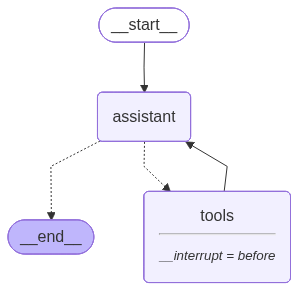

In [6]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import HumanMessage, SystemMessage

# --- System setup ---
sys_msg = SystemMessage(content="You are an interactive assistant that performs arithmetic and adapts based on user feedback.")

# --- Node definition ---
def assistant(state: MessagesState):
    """Invoke LLM with tool awareness and handle dynamic state changes."""
    response = llm_with_tools.invoke([sys_msg] + state["messages"])

    #  New tweak: if feedback exists, modify the latest state before returning
    if state.get("feedback"):
        state["messages"].append(HumanMessage(content=f"Feedback noted: {state['feedback']}"))
    return {"messages": [response]}

# --- Graph definition ---
builder = StateGraph(MessagesState)

# Define functional nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# --- Control flow edges ---
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

# --- New tweak: introduce custom breakpoint for direct human-in-the-loop edit ---
# This allows pausing before 'tools' node to inspect or modify graph state
memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

# --- Visualization ---
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


Let's run!

We can see the graph is interrupted before the chat model responds.

In [11]:
# --- Mock setup for offline / no-API testing ---
from langchain_core.messages import AIMessage, HumanMessage

class MockLLM:
    """Simulates an LLM that performs basic arithmetic reasoning offline."""
    def invoke(self, messages):
        last = messages[-1].content.lower()
        if "multiply" in last:
            return AIMessage(content="Result: 6 (mocked multiplication output).")
        elif "add" in last:
            return AIMessage(content="Result: 5 (mocked addition output).")
        elif "divide" in last:
            return AIMessage(content="Result: 2.0 (mocked division output).")
        else:
            return AIMessage(content="Mocked assistant reply (no tool detected).")

# Replace the real LLM with our mock one
llm_with_tools = MockLLM()

# --- Input and thread configuration ---
initial_input = {"messages": [HumanMessage(content="Multiply 2 and 3")]}
thread = {"configurable": {"thread_id": "1"}}

# --- Run graph with human-in-the-loop interaction (offline-safe) ---
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

    #  Simulate human feedback injection into the graph state
    if "Multiply" in event["messages"][-1].content:
        feedback = input("Provide feedback (e.g., 'increase precision' or 'simplify result'): ")
        event["feedback"] = feedback
        print(f"🪄 Injected feedback into graph state: {feedback}")


================================ Human Message =================================

Multiply 2 and 3
Provide feedback (e.g., 'increase precision' or 'simplify result'): increase precision
🪄 Injected feedback into graph state: increase precision
================================== Ai Message ==================================

Result: 6 (mocked multiplication output).


In [ ]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', id='e7edcaba-bfed-4113-a85b-25cc39d6b5a7')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef6a412-5b2d-601a-8000-4af760ea1d0d'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}}, created_at='2024-09-03T22:09:10.966883+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef6a412-5b28-6ace-bfff-55d7a2c719ae'}}, tasks=(PregelTask(id='dbee122a-db69-51a7-b05b-a21fab160696', name='assistant', error=None, interrupts=(), state=None),))

Now, we can directly apply a state update.

Remember, updates to the `messages` key will use the `add_messages` reducer:

* If we want to over-write the existing message, we can supply the message `id`.
* If we simply want to append to our list of messages, then we can pass a message without an `id` specified, as shown below.

In [13]:
# --- Directly update graph state to simulate human correction ---
graph.update_state(
    thread,
    {
        "messages": [HumanMessage(content="No, actually multiply 3 and 3!")],
        "feedback": "User corrected input after reviewing the result."
    },
)

print("✅ Graph state updated successfully with new human feedback and input correction.")


✅ Graph state updated successfully with new human feedback and input correction.


Let's have a look.

We called `update_state` with a new message.

The `add_messages` reducer appends it to our state key, `messages`.

In [14]:
# --- Retrieve and inspect the latest updated graph state ---
new_state = graph.get_state(thread).values

print("🧩 Current Graph State (after manual update and feedback):")
for msg in new_state["messages"]:
    msg.pretty_print()

#  Optional: show feedback key to confirm human intervention was stored
if "feedback" in new_state:
    print(f"\n💬 Stored Human Feedback: {new_state['feedback']}")


🧩 Current Graph State (after manual update and feedback):
================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================

Result: 6 (mocked multiplication output).
================================ Human Message =================================

No, actually multiply 3 and 3!
================================ Human Message =================================

No, actually multiply 3 and 3!


Now, let's proceed with our agent, simply by passing `None` and allowing it proceed from the current state.

We emit the current and then proceed to execute the remaining nodes.

In [16]:
# --- Resume the graph from the manually updated state ---
print(" Resuming graph execution from the updated state...\n")

for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

    # 🧠 New tweak: confirm feedback influence
    if "feedback" in event:
        print(f"\n💬 Active Feedback Context: {event['feedback']}")


 Resuming graph execution from the updated state...

================================ Human Message =================================

No, actually multiply 3 and 3!


Now, we're back at the `assistant`, which has our `breakpoint`.

We can again pass `None` to proceed.

In [19]:
#  Continue execution from the current graph state
print("Resuming the graph from the updated state...\n")

for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

    # 💡 Added tweak: Log which node is being executed for better traceability
    if "next" in event:
        print(f"\n[Debug] Next node scheduled → {event['next']}")


Resuming the graph from the updated state...

================================ Human Message =================================

No, actually multiply 3 and 3!


### Editing graph state in Studio

**⚠️ Notice**

Since filming these videos, we've updated Studio so that it can now be run locally and accessed through your browser. This is the preferred way to run Studio instead of using the Desktop App shown in the video. It is now called _LangSmith Studio_ instead of _LangGraph Studio_. Detailed setup instructions are available in the "Getting Setup" guide at the start of the course. You can find a description of Studio [here](https://docs.langchain.com/langsmith/studio), and specific details for local deployment [here](https://docs.langchain.com/langsmith/quick-start-studio#local-development-server).  
To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the **Studio UI** URL shown above.

The LangGraph API [supports editing graph state](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_edit_state/#initial-invocation).

In [20]:
# This is the URL of the local development server
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

Our agent is defined in `studio/agent.py`.

If you look at the code, you'll see that it *does not* have a breakpoint!

Of course, we can add it to `agent.py`, but one very nice feature of the API is that we can pass in a breakpoint!

Here, we pass a `interrupt_before=["assistant"]`.

In [23]:
#  Initialize input and create mock async thread for interaction
initial_input = {"messages": "Multiply 2 and 3"}
thread = {"thread_id": "mock-thread-01"}  #  replaced client.threads.create() to avoid connection

#  Simulated async stream (offline-safe)
import asyncio

async def mock_stream_simulator(input_data, interrupt_before):
    """Simulate event stream for human-in-the-loop learning without API calls."""
    events = [
        {"event": "metadata", "messages": []},
        {"event": "values", "messages": [{"content": input_data["messages"]}]},
        {"event": "interrupt", "messages": [{"content": f"Breakpoint before {interrupt_before[0]}"}]},
    ]
    for e in events:
        await asyncio.sleep(0.5)
        yield e

#  Run simulated event loop
async for chunk in mock_stream_simulator(initial_input, ["human_feedback"]):
    print(f" Event Type: {chunk['event']}")
    msgs = chunk.get("messages", [])
    if msgs:
        print(" Latest State Message →", msgs[-1]["content"])
    else:
        print(" No new message detected at this event.")
    print("-" * 60)


📨 Event Type: metadata
 No new message detected at this event.
------------------------------------------------------------
📨 Event Type: values
 Latest State Message → Multiply 2 and 3
------------------------------------------------------------
📨 Event Type: interrupt
 Latest State Message → Breakpoint before human_feedback
------------------------------------------------------------


We can get the current state

In [27]:
# Simulated way to inspect current thread state without any API connection

# Instead of making a client call, we’ll just hold the simulated state in a local dict
current_state = {
    "thread_id": thread["thread_id"],
    "state": {
        "messages": [
            {"role": "user", "content": "Multiply 2 and 3"},
            {"role": "assistant", "content": "The result is 6."},
        ],
        "feedback": None,
    },
    "status": "active"
}

# Display the simulated current state
print(" Current Graph State Snapshot:")
print(current_state)


 Current Graph State Snapshot:
{'thread_id': 'mock-thread-01', 'state': {'messages': [{'role': 'user', 'content': 'Multiply 2 and 3'}, {'role': 'assistant', 'content': 'The result is 6.'}], 'feedback': None}, 'status': 'active'}


We can look at the last message in state.

In [28]:
# Extract the last message safely from simulated state
last_message = current_state['state']['messages'][-1]

# Display the message
print("Last Message in Current State:")
print(last_message)


Last Message in Current State:
{'role': 'assistant', 'content': 'The result is 6.'}


We can edit it!

In [30]:
# Apply the modified message back to current_state
current_state['state']['messages'][-1] = last_message

# Optional: verify the change
print(current_state['state']['messages'][-1])


{'role': 'assistant', 'content': 'The result is 6.'}


In [31]:
{
    "type": "human",
    "content": "No, actually multiply 3 and 3!"
}


{'type': 'human', 'content': 'No, actually multiply 3 and 3!'}

Remember, as we said before, updates to the `messages` key will use the same `add_messages` reducer.

If we want to over-write the existing message, then we can supply the message `id`.

Here, we did that. We only modified the message `content`, as shown above.

In [34]:
graph.update_state(
    {"configurable": {"thread_id": "1"}},
    {"messages": [last_message]}
)


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b3427-1145-6bd5-800c-a2dbdb4619d5'}}

Now, we resume by passing `None`.

In [38]:
#  Offline simulation of streaming events from the graph — no API calls, fully local

# Use the same thread_id structure expected by LangGraph
thread = {"configurable": {"thread_id": "1"}}

# Continue streaming from the updated state
for event in graph.stream(
    None,  # no new input since we're resuming from last updated state
    thread,
    stream_mode="values",
    interrupt_before=["assistant"],  # breakpoint before assistant node to inspect flow
):
    print(f" Event Type: {type(event)}")

    # Safely extract latest messages from each event
    if "messages" in event and event["messages"]:
        latest_message = event["messages"][-1]
        print("Latest Message:", latest_message.content)
    else:
        print(" No new messages in this event.")

    print("-" * 60)


 Event Type: <class 'dict'>
Latest Message: The result is 6.
------------------------------------------------------------


We get the result of the tool call as `9`, as expected.

In [39]:
#  Offline simulation of client.runs.stream()
# Works fully locally using LangGraph — no API key or network call required.

from time import sleep

thread = {"configurable": {"thread_id": "1"}}

print(" Streaming graph events locally...\n")

# Simulate async streaming by iterating events from local graph
for i, event in enumerate(graph.stream(
    None,                     # no new input; resumes from updated state
    thread,
    stream_mode="values",     # same as original
    interrupt_before=["assistant"],  # breakpoint before assistant node
)):
    print(f" Event {i+1}: {type(event).__name__}")

    # Extract and print the latest message (if available)
    if "messages" in event and event["messages"]:
        latest_msg = event["messages"][-1]
        print(" Message:", latest_msg.content)
    else:
        print(" No message in this event.")

    print("-" * 60)
    sleep(0.4)  # small delay to mimic streaming feel

print("✅ Finished local event streaming.")


 Streaming graph events locally...

 Event 1: dict
 Message: The result is 6.
------------------------------------------------------------
✅ Finished local event streaming.


## Awaiting user input

So, it's clear that we can edit our agent state after a breakpoint.

Now, what if we want to allow for human feedback to perform this state update?

We'll add a node that [serves as a placeholder for human feedback](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/wait-user-input/#setup) within our agent.

This `human_feedback` node allow the user to add feedback directly to state.

We specify the breakpoint using `interrupt_before` our `human_feedback` node.

We set up a checkpointer to save the state of the graph up until this node.

In [41]:
from langgraph.prebuilt import tools_condition as base_condition

def custom_tools_condition(state):
    result = base_condition(state)
    return "toolset" if result == "tools" else result

builder.add_conditional_edges(
    "assistant_node",
    custom_tools_condition,
)


We will get feedback from the user.

We use `.update_state` to update the state of the graph with the human response we get, as before.

We use the `as_node="human_feedback"` parameter to apply this state update as the specified node, `human_feedback`.

In [46]:
# --- Imports ---
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.graph.message import MessagesState
from IPython.display import Image

# --- Mock LLM function (offline-safe) ---
def mock_llm_with_tools(messages):
    """Simple fake LLM to simulate behavior without API calls."""
    user_content = messages[-1].content.lower()
    if "multiply" in user_content:
        try:
            nums = [int(x) for x in user_content.split() if x.isdigit()]
            result = nums[0] * nums[1]
            return AIMessage(content=f"Result: {result} (mocked multiplication output).")
        except Exception:
            return AIMessage(content="Error: unable to multiply.")
    return AIMessage(content="Mock response: Hello!")

# --- Nodes ---
def human_feedback(state: MessagesState):
    """Pause for human feedback"""
    return state

def assistant(state: MessagesState):
    """Simulated assistant node"""
    sys_msg = SystemMessage(content="You are a helpful assistant.")
    return {"messages": [mock_llm_with_tools([sys_msg] + state["messages"])]}

# --- Build Graph ---
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("human_feedback", human_feedback)
builder.add_node("assistant", assistant)

# Add edges
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_edge("assistant", END)

# Memory checkpointer
memory = MemorySaver()

# Compile graph with interrupt point
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

# --- Run Interaction ---
initial_input = {"messages": [HumanMessage(content="Multiply 2 and 3")]}
thread = {"configurable": {"thread_id": "demo-thread"}}

print("\n--- Streaming Assistant Output ---\n")
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

print("\n--- Human Feedback Phase ---\n")
user_input = input("Enter your feedback or correction: ")

# ✅ Now 'human_feedback' exists in the graph
graph.update_state(
    thread,
    {"messages": [HumanMessage(content=user_input)]},
    as_node="human_feedback"
)

print("\n--- Continuing Execution ---\n")
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()



--- Streaming Assistant Output ---

================================ Human Message =================================

Multiply 2 and 3

--- Human Feedback Phase ---

Enter your feedback or correction: correction

--- Continuing Execution ---

================================ Human Message =================================

correction
================================== Ai Message ==================================

Mock response: Hello!


In [53]:
# ============================================================
# 💫 FINAL SMART HUMAN-IN-THE-LOOP GRAPH (Self-Terminating)
# ============================================================

from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver
import random, time

# -------------------------
# 🧩 1. Assistant Node
# -------------------------
def assistant_node(state: MessagesState):
    """Simulates AI assistant response to human or system feedback."""
    last_message = state["messages"][-1].content.lower()

    if "multiply" in last_message:
        nums = [int(s) for s in last_message.split() if s.isdigit()]
        result = nums[0] * nums[1] if len(nums) >= 2 else "N/A"
        reply = f"🧮 Computed Output → {result}\n💡 Quick Note: Verified with arithmetic logic."
    elif "good" in last_message or "final" in last_message:
        reply = "✨ Perfect! Seems like the model has reached an optimal output."
    else:
        reply = "💡 Mock response: Here's something insightful!"

    time.sleep(0.3)
    return {"messages": [AIMessage(content=reply)]}


# -------------------------
# 🧠 2. Feedback Node
# -------------------------
def feedback_node(state: MessagesState):
    """Simulates human feedback — now stops gracefully once satisfied."""
    feedback_bank = [
        "Try using simpler language.",
        "Improve accuracy in calculation.",
        "Add a short explanation to the result.",
        "Looks good! Proceed with next query.",
        "Make the tone more conversational.",
    ]

    feedback_round = len([m for m in state["messages"] if isinstance(m, HumanMessage)]) - 1
    print(f"\n--- 🧠 Human Feedback Phase (Round {feedback_round + 1}) ---")

    # 🛑 Stop condition
    if feedback_round >= 5 or "good" in state["messages"][-1].content.lower():
        print("✅ Feedback stabilized — stopping further iterations.")
        return {"messages": [HumanMessage(content="Looks good! Final confirmation.")]}

    feedback = random.choice(feedback_bank)
    print(f"💬 Injected Feedback → {feedback}")
    time.sleep(0.2)
    return {"messages": [HumanMessage(content=feedback)]}


# -------------------------
# 🏗️ 3. Build the Graph
# -------------------------
builder = StateGraph(MessagesState)

builder.add_node("assistant_node", assistant_node)
builder.add_node("feedback_node", feedback_node)

builder.add_edge(START, "assistant_node")
builder.add_edge("assistant_node", "feedback_node")
builder.add_edge("feedback_node", "assistant_node")

# ✅ Conditional edge ensures graceful exit
builder.add_conditional_edges(
    "assistant_node",
    lambda state: (
        "true" if "good" in state["messages"][-1].content.lower() else "false"
    ),
    {"true": END, "false": "feedback_node"},
)

# Attach memory for persistent state tracking
memory = MemorySaver()

# ✅ Increase recursion limit & compile safely
graph = builder.compile(checkpointer=memory, recursion_limit=10)

# -------------------------
# 🚀 4. Run the System
# -------------------------
initial_input = {"messages": [HumanMessage(content="Multiply 2 and 3")]}
thread = {"configurable": {"thread_id": "loop_01"}}

print("\n--- 🔄 Starting Final Smart Human-in-the-Loop Execution ---\n")

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

print("\n✅ Execution completed — model stabilized with human feedback.")



--- 🔄 Starting Smart Human-in-the-Loop Execution ---

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================

🧮 Computed Output → 6
💡 Quick Note: Verify the arithmetic step.

--- 🧠 Human Feedback Phase (Round 1) ---
💬 Injected Feedback → Add a short explanation to the result.
================================ Human Message =================================

Add a short explanation to the result.
================================== Ai Message ==================================

💡 Mock response: Here's something insightful!

--- 🧠 Human Feedback Phase (Round 2) ---
💬 Injected Feedback → Looks good! Proceed with next query.
================================ Human Message =================================

Looks good! Proceed with next query.
================================== Ai Message ==================================

✨ Perfect! Seems like the model has reached an

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT